In [1]:
import mysql.connector 
import config_aws
import requests
# import time  # This is just to be able to make multiple calls to the API in spaced out time intervals
# import string # For the remove_special_chars function
import pandas as pd
from sodapy import Socrata
import sqlalchemy as db
import pandas as pd
# from helpers import (query, query_list)

In [2]:
#instantiate the connection and table

engine = db.create_engine(f'mysql+mysqlconnector://{config_aws.user}:{config_aws.pw}@{config_aws.host}/building_permits')

connection = engine.connect()
metadata=db.MetaData()

In [3]:
def query(q):
    try:
        return pd.read_sql_query(q, engine)
    # Pass when no data is returned    
    except ResourceClosedError:
        pass

def query_list(col, table, distinct = True):
    elts = ['SELECT',
            'DISTINCT' if distinct else '',
            col,
            'FROM',
            table]
    query_str = ' '.join(elts)
    df = query(query_str)
    l = df.iloc[:,0].tolist()
    return l

In [4]:
raw_data = query('SELECT self_cert, owner_s_business_type, non_profit, residential, job_type, work_type, zip_code FROM dob_permits WHERE dob_permits.borough = "MANHATTAN"')

In [5]:
raw_data.head()

,self_cert,owner_s_business_type,non_profit,residential,job_type,zip_code
0,N,CORPORATION,N,YES,A2,10019
1,N,CONDO/CO-OP,N,YES,A2,10025
2,N,CONDO/CO-OP,N,YES,A2,10025
3,Y,PARTNERSHIP,N,No,A3,10022
4,N,CORPORATION,N,YES,A1,10036


In [ ]:
# def full_clean(data):
    
#     #create new column 
#     data['time_to_issuance']=data['issuance_date'] - data['filing_date']
    
#     #create new column
#     data['cat_owner_business_type'] = data['owner_s_business_type'].map(lambda x: ob_type_categorize(x))
    
#     data['cat_work_type'] = data['work_type'].map(lambda x: cat_work(x))
    
#     #create new column for 
#     data['time_to_startdate'] = data['issuance_date'] - data['job_start_date']
    
#     return data

In [6]:
df =raw_data

In [7]:
#drop dependent variable
y = df['residential']
X = df.drop(columns='residential', axis=1)
# X.head()

**Train Test Split**

In [8]:
#train test split
import numpy as np
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [46]:
X_train.shape

(328878, 5)

**One Hot Encode**

In [10]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz
from sklearn.preprocessing import OneHotEncoder
from IPython.display import Image  
from sklearn.tree import export_graphviz
from pydotplus import graph_from_dot_data

In [51]:
#One-hot encode the training data
ohe = OneHotEncoder(drop='first')

ohe.fit(X_train)
X_train_ohe = ohe.transform(X_train).toarray()

# Show:
ohe_df = pd.DataFrame(X_train_ohe, columns=ohe.get_feature_names(X_train.columns))
ohe_df.head()

,self_cert_NA,self_cert_Y,owner_s_business_type_CORPORATION,owner_s_business_type_DCAS,owner_s_business_type_DOE,owner_s_business_type_HHC,owner_s_business_type_HPD,owner_s_business_type_INDIVIDUAL,owner_s_business_type_NY STATE,owner_s_business_type_NYC AGENCY,...,zip_code_10175,zip_code_10176,zip_code_10177,zip_code_10178,zip_code_10271,zip_code_10278,zip_code_10280,zip_code_10281,zip_code_10282,zip_code_10463
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
#get column names from the dataframe
col_names = ohe_df.columns

In [47]:
X_train_ohe.shape

(328878, 102)

**Decision Tree**

In [12]:
# Create the classifier, fit it on the training data and make predictions on the test set
clf = DecisionTreeClassifier(criterion='entropy', max_depth = 5)

clf.fit(X_train_ohe, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

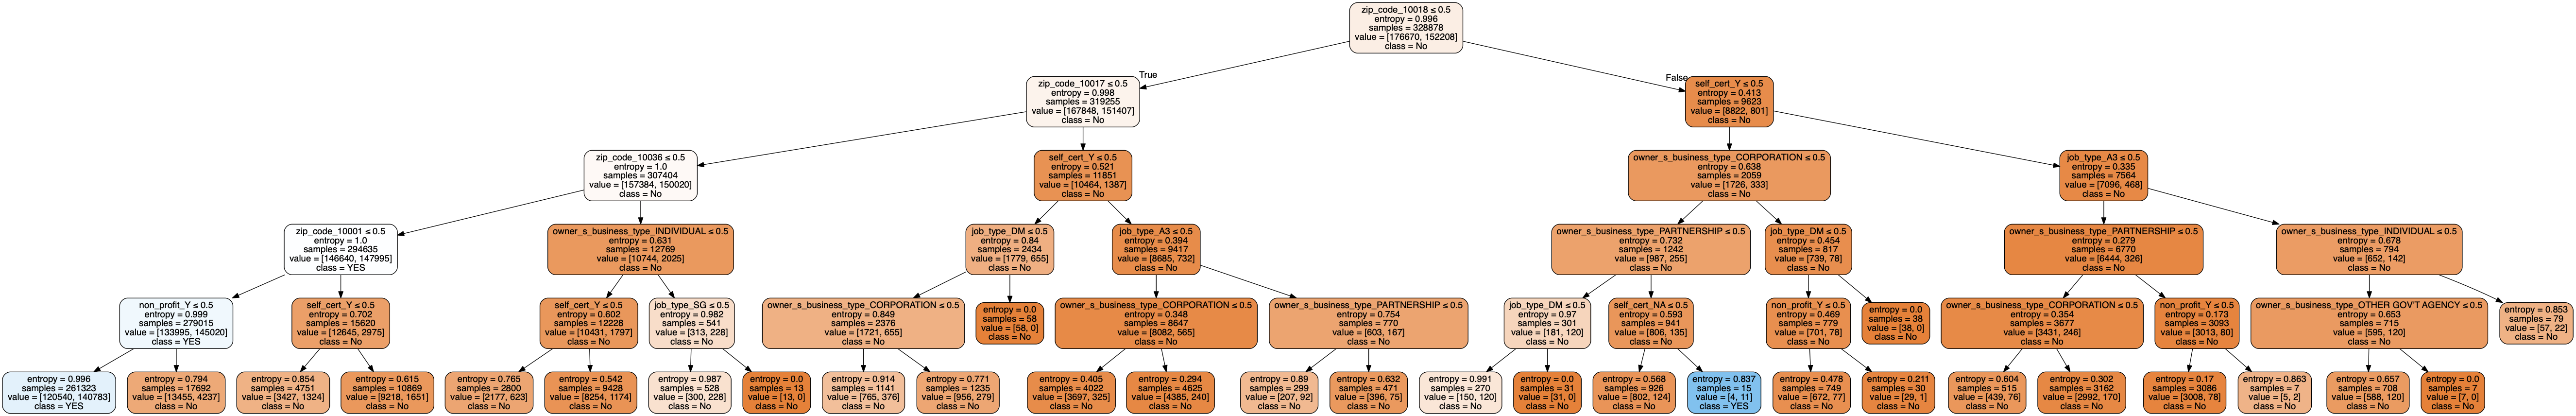

In [13]:
# Create DOT data
dot_data = export_graphviz(clf, out_file=None, 
                           feature_names=ohe_df.columns,  
                           class_names=np.unique(y).astype('str'), 
                           filled=True, 
                           rounded=True, 
                           special_characters=True)

# graph
graph = graph_from_dot_data(dot_data)

# Show graph
Image(graph.create_png())

In [14]:
X_test_ohe = ohe.transform(X_test)
y_preds = clf.predict(X_test_ohe)

print('Accuracy: ', accuracy_score(y_test, y_preds))

Accuracy:  0.5968864023351983


In [54]:
type(X_test_ohe)
#using the columns from the onehot, make df

ValueError: Shape of passed values is (82220, 1), indices imply (82220, 102)

In [21]:
clf.feature_importances_

array([7.63236380e-04, 3.46892801e-02, 4.42449557e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.41760965e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 7.24062031e-05, 4.78565588e-03, 1.73323973e-01,
       0.00000000e+00, 8.85958322e-03, 2.19985809e-03, 0.00000000e+00,
       4.04874816e-04, 1.92437297e-01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.01661684e-01,
       1.91798061e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.78161985e-01, 0.00000000e+00,
      

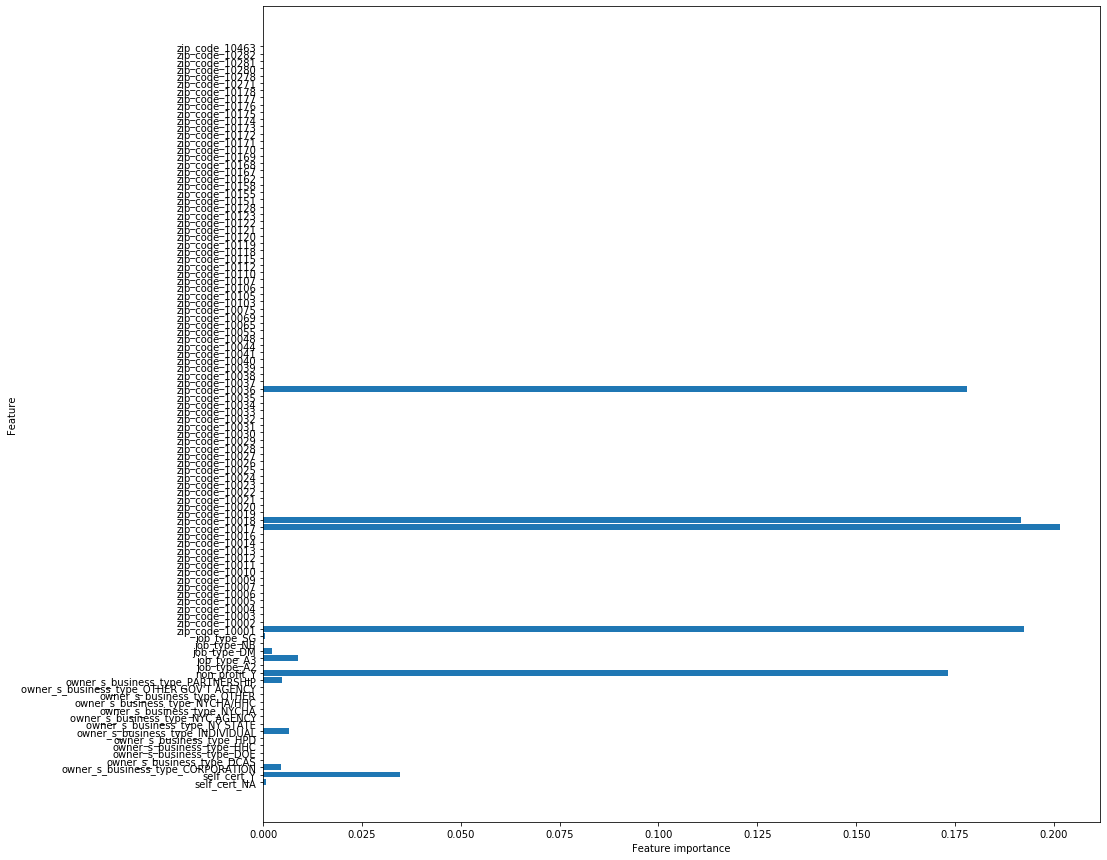

In [56]:
import matplotlib.pyplot as plt

def plot_feature_importances(model):
    
    n_features = X_train_ohe.shape[1]
    
    plt.figure(figsize=(15,15))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    
    plt.yticks(np.arange(n_features), col_names) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(clf)

Confusion Matrix

In [ ]:
#make X_test into a dataframe
#make Y_test into a dataframe

In [36]:
# Test set predictions
prediction = clf.predict(X_test)

# Confusion matrix and classification report
print(confusion_matrix(y_test, prediction))
print(classification_report(y_test, prediction))

ValueError: could not convert string to float: 'N'

**Random Forest**

In [20]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier

Bagging Trees:

A Bagging classifier is an ensemble meta-estimator that fits base classifiers each on random subsets of the original dataset and then aggregate their individual predictions (either by voting or by averaging) to form a final prediction. Such a meta-estimator can typically be used as a way to reduce the variance of a black-box estimator (e.g., a decision tree), by introducing randomization into its construction procedure and then making an ensemble out of it.

- n_estimators = The number of base estimators in the ensemble.

In [39]:
bagging_trees = BaggingClassifier(DecisionTreeClassifier(criterion='gini', max_depth=5), 
                                 n_estimators=20)

In [41]:
bagging_trees.fit(X_train, y_train)

ValueError: could not convert string to float: 'Y'

In [ ]:
y_predict = clf.predict(X_test)